In [ ]:
!pip install numpy networkx seaborn matplotlib

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import approximation as approx

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

In [3]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField
from ahs_utils import show_register, show_global_drive

# Generate MIS problem instance

In [4]:
# Define square lattice atom arrangement

def prepare_atom_configuration(
    n_x, n_y, a=5e-6
):
    """Prepare atom arrangement on a rectangular lattice
    Args:
        n_x: number of atoms along horizontal axis
        n_y: number of atoms along vertical axis
    Return:
        AtomRegister
    """
    register = AtomArrangement()
    for i in range(n_x):
        for j in range(n_y):
            register.add([i * a, j * a])

    return register

In [13]:
H = Hamiltonian()

nx, ny = 5, 5
n_atoms = nx*ny

atoms = prepare_atom_configuration(nx, ny, a=5.5e-6)


In [14]:
Omega_max = 55e6  # rad / seconds
Delta_max = 16e6
Delta_min = -16e6

t_max = 4e-6  # the duration of the program
delta_t = 0.25e-6


# e.g. constant Rabi frequency
Omega = TimeSeries()
Omega.put(0.0, 0.).put(delta_t, Omega_max).put(t_max-delta_t, Omega_max).put(t_max, 0)


# e.g. all-zero phase and detuning
phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])

times = [0, delta_t, t_max-delta_t, t_max]
Delta_global = TimeSeries().put(0.0, Delta_min).put(delta_t, Delta_min).put(t_max-delta_t, Delta_max).put(t_max, Delta_max)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta_global
)

H += drive

In [15]:
ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=atoms
)

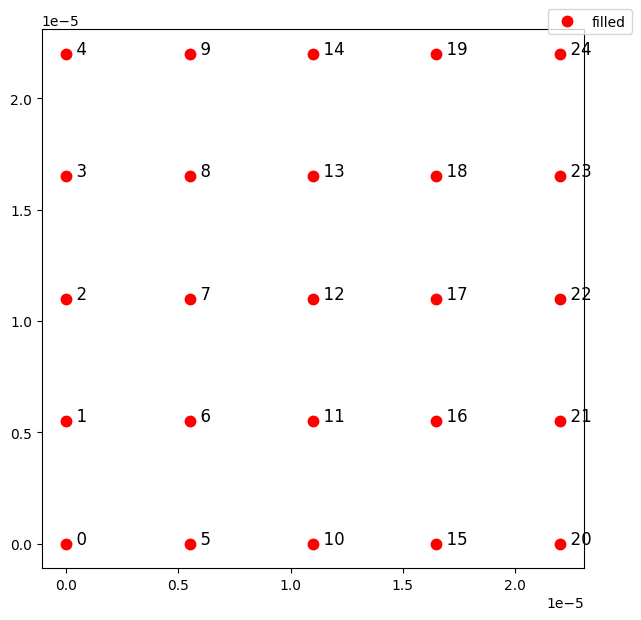

In [16]:
show_register(
    register = atoms, 
    what_to_draw = "circle", # or 'bond' 
    show_atom_index=True
)

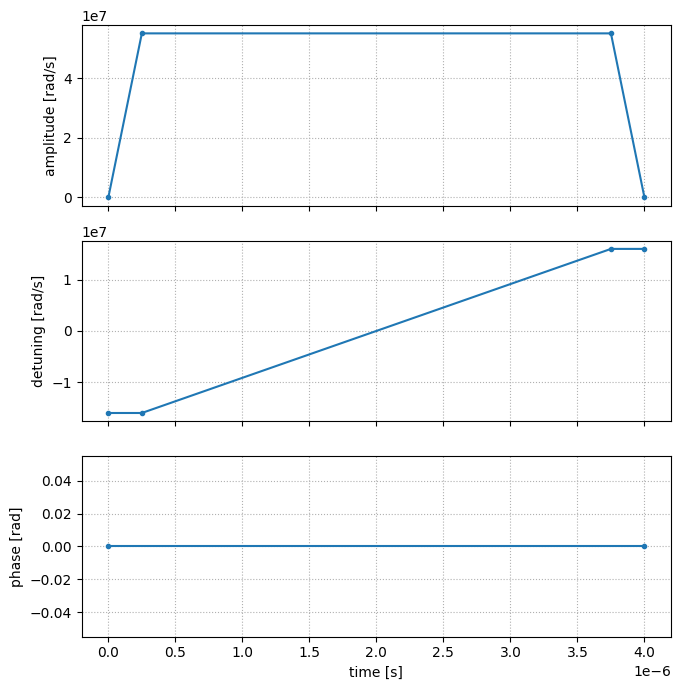

In [17]:
show_global_drive(drive)

In [18]:
ahs_str = ahs_program.to_ir().json()

In [19]:
import json
ahs_ir = ahs_program.to_ir()
json_data = json.loads(ahs_ir.json())
json_string = json.dumps(json_data, indent=4) 

fname = "experiments/mis/ahs_program.json"
with open(fname, "w") as json_file:
    json_file.write(json_string)   

# Defining evolution protocol

## Running Julia MPS simulator

In [ ]:
import subprocess

dir_name = 'experiments/mis'

subprocess.run(['julia', '../mps_runner.jl', 
                '--program-path', fname, 
                '--experiment-path', dir_name]
              )



You may supply additional command line arguments to `mps_runner.jl`. To learn more about them, run `julia mps_braket.jl --help`.

## Look at experiment results: square lattice with NNN interactions [pruned Union Jack lattice]

In [22]:
# square lattice: 5 x 5

psi_samples = pd.read_csv(f"{dir_name}/mps_samples.csv")
coords = pd.read_csv(f"{dir_name}/atom_coordinates.csv")
filling = pd.read_csv(f"{dir_name}/filling.csv")
density = pd.read_csv(f"{dir_name}/mps_density.csv")

### Visualize a few samples [red - Ry, green - Ground]

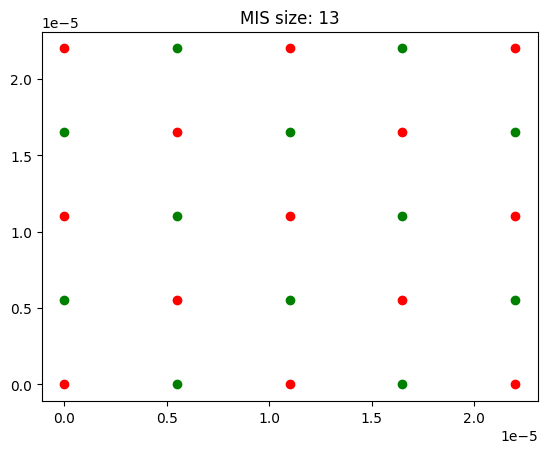

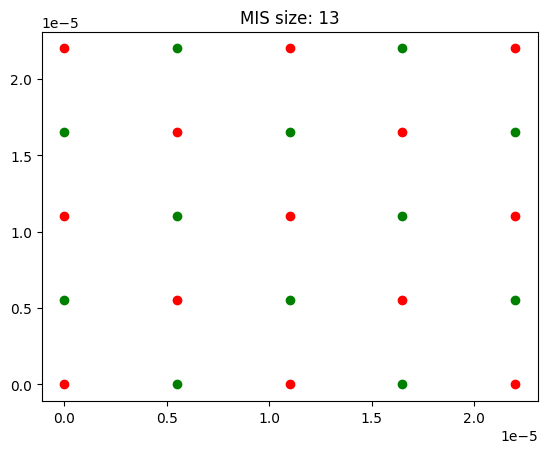

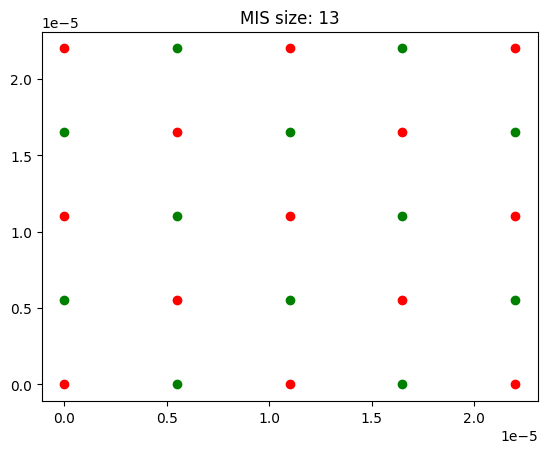

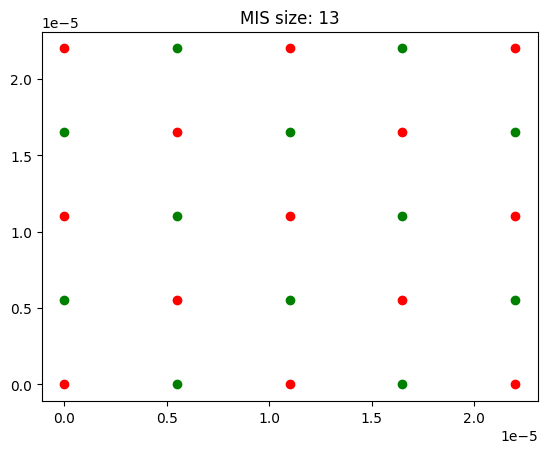

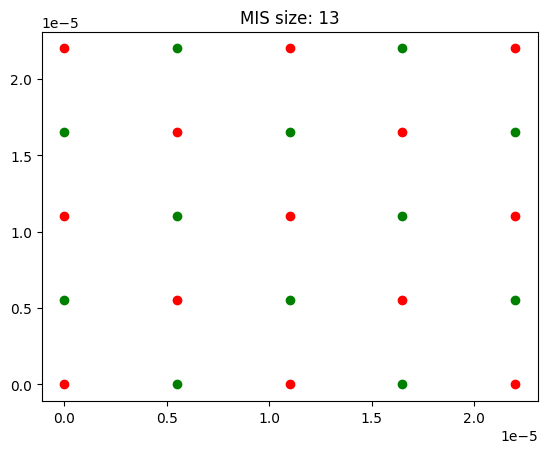

In [23]:
for sample in psi_samples.values[:5]:
    plt.plot(coords.T.values[sample == 0, 0], coords.T.values[sample == 0, 1], 'o', c='g')
    plt.plot(coords.T.values[sample == 1, 0], coords.T.values[sample == 1, 1], 'o', c='r')
    plt.title(f"MIS size: {sum(sample)}")
    plt.show()

#### Visualize average densities

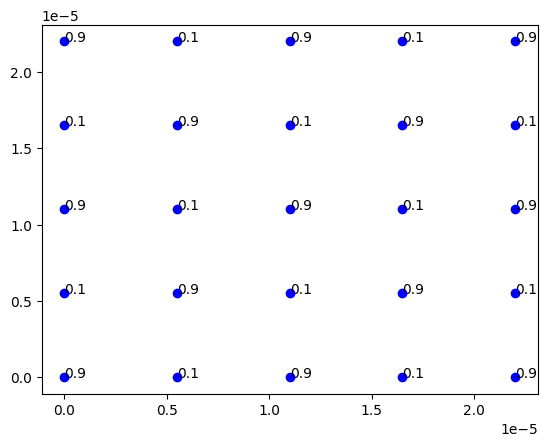

In [24]:
atom_coords = coords.T.values
plt.plot(atom_coords[:, 0], atom_coords[:, 1], 'o', c='b')

for i, txt in enumerate(density.values[-1]):
    plt.annotate(round(txt, 1), (atom_coords[i, 0], atom_coords[i, 1]))

### Distribution of MIS sizes [without postselection]

Text(0.5, 1.0, 'Num Rydberg atoms [MIS size, no postselect]')

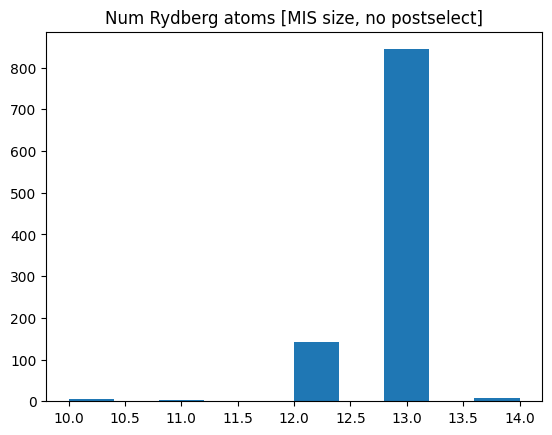

In [25]:
plt.hist(psi_samples.values.sum(axis=1));
plt.title("Num Rydberg atoms [MIS size, no postselect]")

### Compute MIS classically

In [28]:
rows = 5  # Number of rows
cols = 5  # Number of columns

# Create a grid graph for the square lattice
G = nx.grid_2d_graph(rows, cols)
G = nx.convert_node_labels_to_integers(G)

# Prune graph
nodes_to_delete = np.where(filling.values == 0)[1]
G.remove_nodes_from(nodes_to_delete)

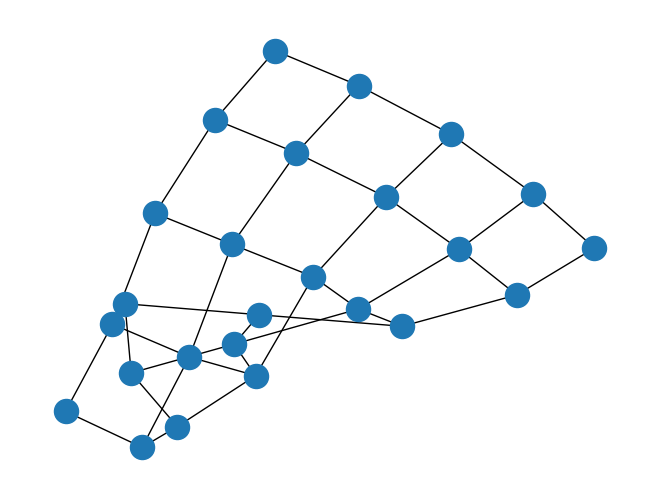

In [29]:
nx.draw(G)

In [30]:
I = approx.maximum_independent_set(G)

In [31]:
print(f"MIS size: {len(I)}")

MIS size: 13
